# Main Objective
There are 2 classes bag, namely: 'Keepall 55' and 'Speedy 30'. Image clasification system should determine for a given picture from one of those 2 pictures.

# Hypothesis
1. Distinction between 2 types of bag/purse solely based on shape and size.
2. Distinction does not depend on colors (they have the same colors for each)
3. Image preprocessing before feed it to the model needs to be performed:
    - Edge detection
    - Texture detection and filtering
    - Augmentation (optional)
4. Deep learning neural network can distinguish the bags:
    - simple CNN
    - Restnet

## Import dependencies

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import skimage
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator 

### Dataset path

In [ ]:
ds_master = "./Dataset"
ds_keepall55 = os.path.join(ds_master, 'Keepall 55')
ds_keepall55_b = os.path.join(ds_master, 'Keepall Bandouliere 55')
ds_speedy = os.path.join(ds_master, 'Speedy 30')
ds_folders = [ds_keepall55, ds_speedy]

### Pre-processing

Function helper

In [ ]:
# def reshape and save
def reshape_and_save(path):
    height = 1200
    width = 1200
    img = cv2.imread(path) # img is np.array
    resized_img = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(path, resized_img) # save with new size

for folder in ds_folders:
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        # reshape and save
        reshape_and_save(img_path)
    

### Try Pre-processing

Function helper

In [ ]:
def image_show_path(path, name="bag_name", color='gray'):
    img = mpimg.imread(path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap=color)
    plt.title(name)
    plt.show()
    
def image_show_arr(img_arr, name="bag_name", color='gray'):
    plt.figure(figsize=(5, 5))
    plt.imshow(img_arr, cmap=color)
    plt.title(name)
    plt.show()
    
def hist_generator(data, name="histogram"):
    plt.figure(figsize=(5, 5))
    plt.hist(data.ravel(), bins=256, histtype='bar', color='blue')
    plt.title(name)
    plt.show()

Get example for keepall bag and speedy

In [ ]:
import glob
examples_keepall = glob.glob(ds_keepall55 + "\\*") 
examples_speedy = glob.glob(ds_speedy + "\\*")

Original photo

In [ ]:
# get first image as an example
example_keepall = examples_keepall[0]
example_speedy = examples_speedy[0]

# read with opencv and show image (keepall)
img_keepall = cv2.imread(example_keepall)
img_keepall = cv2.cvtColor(img_keepall, cv2.COLOR_BGR2GRAY)
img_keepall = cv2.resize(img_keepall, (224, 224), interpolation=cv2.INTER_LINEAR)
image_show_arr(img_keepall, "keepall_original")

# get histogram
hist_generator(img_keepall)

# read with opencv and show image (speedy)
img_speedy = cv2.imread(example_speedy)
img_speedy = cv2.cvtColor(img_speedy, cv2.COLOR_BGR2GRAY)
img_speedy = cv2.resize(img_speedy, (224, 224), interpolation=cv2.INTER_LINEAR)
image_show_arr(img_speedy, "speedy_original")

# get histogram
hist_generator(img_speedy)

In [ ]:
img_keepall.shape

In [ ]:
# try filters
from skimage import filters
from skimage import feature

# uncanny edge detection
keepall_uncanny = feature.canny(img_keepall)
# keepall_uncanny = keepall_uncanny.astype('float')
# image_show_arr(keepall_uncanny, name='keepall_uncanny')

# sobel
keepall_sobel = filters.sobel(img_keepall)
keepall_sobel = keepall_sobel.astype(np.float)
image_show_arr(keepall_sobel, name='keepall_sobel')

# roberts filter
keepall_roberts = filters.roberts(img_keepall)
keepall_roberts = keepall_roberts.astype(np.float)
image_show_arr(keepall_roberts, name='keepall_roberts')




Gabor filter

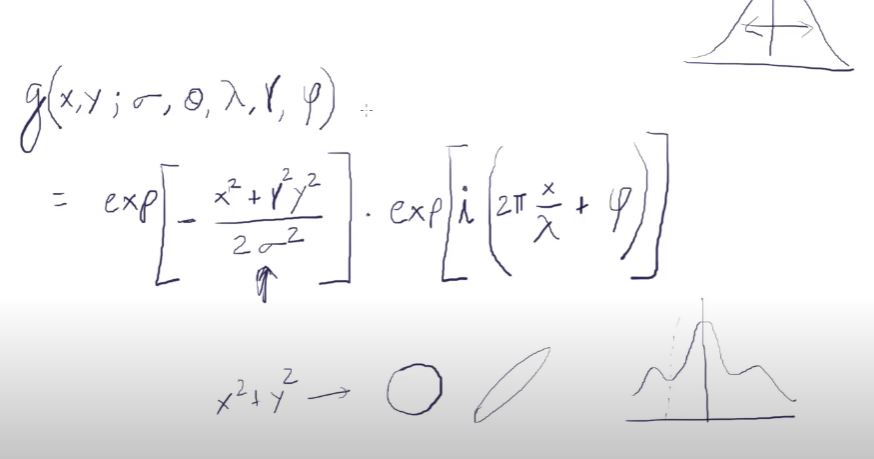

In [ ]:
# try gabor filter
size = 5 # 10 and 5
sigma = 3 # 5 and 3
theta = 1*np.pi / 2
lambd = 1*np.pi / 4
gamma = 0.1
psi = 0
gabor_kernel1 = cv2.getGaborKernel((size, size), sigma, theta, lambd, gamma, psi, ktype= cv2.CV_32F)
gabor_kernel2 = cv2.getGaborKernel((size, size), sigma, 0*theta, lambd, gamma, psi, ktype= cv2.CV_32F)
gabor_kernel = gabor_kernel1 + gabor_kernel2

image_show_arr(gabor_kernel, name='gabor kernel')

In [ ]:
filtered_keepall = cv2.filter2D(keepall_sobel, -1, gabor_kernel)
filtered_keepall = filtered_keepall.astype(np.float)
image_show_arr(filtered_keepall, name='Filtered keepall')
hist_generator(filtered_keepall, name="filtered histogram keepall")

In [ ]:
filtered_keepall.dtype

### Batch Image Processing

In [ ]:
import glob
from skimage import filters

class ImageProcessing():
    def __init__(self):
        
        ds_master = "./Dataset"
        ds_keepall55 = os.path.join(ds_master, 'Keepall 55')
        ds_keepall55_b = os.path.join(ds_master, 'Keepall Bandouliere 55')
        ds_speedy = os.path.join(ds_master, 'Speedy 30')

        # list of example fullpath
        self.examples_keepall = glob.glob(ds_keepall55 + "\\*")
        self.examples_speedy = glob.glob(ds_speedy + "\\*")
        
        # get one example each class
        self.example_keepall = self.examples_keepall[0]
        self.example_speedy = examples_speedy[0]
    
    def open_and_preprocess(self, img_path):
        # read as grayscale
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # resize to 224x224
        SIZE = 224
        img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_LINEAR)
        
        # reshape to (SIZE, SIZE, 3) -> 3 duplicate 
#         dummy_arr = np.zeros((224, 224, 1))
#         dummy_arr[:, :, 0] = img
#         dummy_arr[:, :, 1] = img
#         dummy_arr[:, :, 2] = img
#         img = dummy_arr
        return img # the shape is (224, 224, 3) -> all gray
        
    def gabor1(self, img):
        size = 5
        sigma = 3
        theta = 1*np.pi / 2
        lmda = 1*np.pi / 4
        gamma = 0.1
        psi = 0
        
        # generate gabor filter
        gabor_hor  = cv2.getGaborKernel((size, size), sigma, theta, lmda, gamma, psi, ktype=cv2.CV_32F)
        gabor_vert = cv2.getGaborKernel((size, size), sigma, 0*theta, lmda, gamma, psi, ktype=cv2.CV_32F)
        gabor = gabor_vert + gabor_hor
        
        # filter image
        fimg = cv2.filter2D(img, -1, gabor)
        fimg = fimg.astype(np.float)
        
        return fimg
    
    def gabor2(self, img):
        size = 10
        sigma = 5
        theta = 1*np.pi / 2
        lmda = 1*np.pi / 4
        gamma = 0.1
        psi = 0
        
        # generate gabor filter
        gabor_hor = cv2.getGaborKernel((size, size), sigma, theta, lmda, gamma, psi, ktype=cv2.CV_32F)
        gabor_vert = cv2.getGaborKernel((size, size), sigma, 0*theta, lmda, gamma, psi, ktype=cv2.CV_32F)
        gabor = gabor_vert + gabor_hor
        
        # filter image
        fimg = cv2.filter2D(img, -1, gabor)
        fimg = fimg.astype(np.float)
        
        return fimg
    
    def __call__(self):
        
        # dataset
        dataset = list()
        
        # keepall dataset
        for img_path in self.examples_keepall:

            # open and preprocess
            img = self.open_and_preprocess(img_path) # shape-> (224, 224, 3)

            # sobel filter
            img = filters.sobel(img)

            # gabor 1
            fmig_gabor1 = self.gabor1(img)
            label = np.array([0], dtype='object')
            tuple_gabor1 = (fmig_gabor1, label)

            # gabor 2
            fmig_gabor2 = self.gabor2(img)
            tuple_gabor2 = (fmig_gabor2, label)
            
            # append and labelling
            
            dataset.append(tuple_gabor1)
            dataset.append(tuple_gabor2)
            
        # speedy dataset
        for img_path in self.examples_speedy:
            # open and preprocess
            img = self.open_and_preprocess(img_path) # shape-> (224, 224, 3)

            # sobel filter
            img = filters.sobel(img)

            # gabor 1
            fmig_gabor1 = self.gabor1(img)
            label = np.array([1], dtype='object')
            tuple_gabor1 = (fmig_gabor1, label)

            # gabor 2
            fmig_gabor2 = self.gabor2(img)
            tuple_gabor2 = (fmig_gabor2, label)
            
            # append and labelling
            
            dataset.append(tuple_gabor1)
            dataset.append(tuple_gabor2)
        
        dataset = np.array(dataset)
        print(dataset.shape)
        print(dataset[0])
        return dataset
            

Create dataset and shuffle

In [ ]:
image_processing = ImageProcessing()
dataset= image_processing() # array([(data, label), (data, label), dst]

In [ ]:
# shuffle
np.random.shuffle(dataset)

Checking

In [ ]:
image_show_arr(dataset[0][0])

In [ ]:
print(dataset[0][1])

In [ ]:
dataset[0][0].shape

### Train, validate split

unwrap dataset

In [ ]:
# unwrap dataset
data = list()
labels = list()

for i, example in enumerate(dataset):
    d, l = example
    data.append(d)
    labels.append(l)
    
data = np.array(data, dtype='float')
labels = np.array(labels, dtype='float')
labels = labels.ravel()

In [ ]:
print(f"{data.shape}, {len(labels)}")

train validate split

In [ ]:
from sklearn.model_selection import train_test_split

# train, validation, split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, shuffle=True)

In [ ]:
image_show_arr(X_train[4], "x_train")

In [ ]:
print(f"{y_train[2]}")

### Sequential Model

Build

In [ ]:
# expand dims and scaling
X_train = np.expand_dims(X_train, axis=-1)
X_train = X_train.astype(np.float) / 255

X_val = np.expand_dims(X_val, axis=-1)
X_val = X_val.astype(np.float) / 255

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

In [ ]:
print(f"{X_train.shape} {y_train.shape}")
print(f"{X_val.shape} {y_val.shape}")

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.activations import relu, sigmoid

# basic cnn

# build sequential model
model = keras.models.Sequential()

# convolutional model
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# flatten
model.add(layers.Flatten())

# dense layer
model.add(layers.Dense(64, activation='relu'))

# dense layer
model.add(layers.Dense(1, activation='sigmoid'))

# compile
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Summary

In [ ]:
model.summary()

In [ ]:
model.name

Train

In [ ]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_val, y_val), validation_steps=10)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.axis([-1, len(history.history['accuracy']), 0, 1.1])
plt.show()

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
model.name

In [ ]:
# save model
import datetime 
time= datetime.datetime.now()

path = r'./models'
name = model.name + "-" + time.strftime('%d') +time.strftime('%m')+time.strftime('%y')
model.save(os.path.join(path, name))

In [ ]:
# https://stats.stackexchange.com/questions/418868/100-accuracy-on-training-high-accuracy-on-testing-as-well-what-does-this-mean
# https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/

### Try application

In [ ]:
# test path
test_path = './Dataset\test'
test_photos = glob.glob(test_path + "\\*")
test_photos

In [ ]:
# load model
from tensorflow.keras.models import load_model
my_model = load_model('./models\sequential_2-160222')

In [ ]:
# labelling
labels = ['keepall', 'speedy']
y_label_test = list()
for i in range(40):
    if i < 20:
        y_label_test.append(0) # keepall
    else:
        y_label_test.append(1) # speedy

y_label_test = np.array(y_label_test).astype('float')
y_label_test = np.expand_dims(y_label_test, axis=1)
y_label_test.shape

In [ ]:
import re

# result y_predict
y_predict = list()

# process image
image_processing = ImageProcessing()
for photo in test_photos:
    
    try:
        name_search = re.search(r"\\(\w+)\.", photo)
        name = name_search[1]
        
        # open and preprocessiing
        img = image_processing.open_and_preprocess(photo)
        # edge detection
        img = filters.sobel(img)
        # texture removement
        img = image_processing.gabor1(img)
        img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)

        # predictions
        prediction = my_model.predict(img)
        prediction = prediction.astype(np.uint8)
        y_predict.append(prediction[0][0])
        
        print(f"predicted: {labels[prediction[0][0]]}, actual name: {name}")
    
    except:
        print(f"{photo} not recognize")

y_predict = np.array(y_predict)
y_predict = np.expand_dims(y_predict, axis=1)
    
    

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_label_test, y_predict)
df_cm = pd.DataFrame(cm, index=['true', 'false'], columns=['positive', 'negative'])
df_cm